In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import extract
import visualize
from sklearn import tree
import pydotplus
import seaborn as sns
import time

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [3]:
d = extract.get_data()
d = extract.clean_data(d)

/home/mark/Math/bondproject/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/mark/Math/bondproject/venv/local/lib/python2.7/site-packages/pandas/core/indexing.py:297: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [4]:
d.head()

,tradeid,cusip,amount,price,yield,tradedate,tradetype,name,state,coupon,maturity,issuesize,issuetype,issuesource,bidcount,rtg
0,317.0,45471AKG6,5000.0,99.507,4.037,2.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6694.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
1,318.0,45471AKG6,30000.0,99.410,4.045,2.0,Sale_to_Customer,indiana st fin auth-a,Indiana,4.00,6694.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
2,319.0,45471AKG6,30000.0,99.290,4.054,2.0,Purchase_from_Customer,indiana st fin auth-a,Indiana,4.00,6694.0,88930000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,6
3,333.0,45471AMY5,15000.0,103.145,3.717,2.0,Sale_to_Customer,in fin auth-major,Indiana,4.25,6482.0,9520000.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",NaN,9
4,378.0,4550572N8,150000.0,114.082,2.060,2.0,Sale_to_Customer,in fin auth-ref-a,Indiana,5.00,2953.0,22530000.0,REVENUE BONDS,WATER REVENUE,NaN,1


In [5]:
s0 = pd.read_csv("./data/price_change_data.csv", usecols = ['d_index', 'tradetype',
		'state', 'coupon', 'maturity', 'issuetype', 'issuesource', 'rtg',
		'tradedate', 'dprice', 'holdtime'])

In [6]:
s0.head()

,tradedate,tradetype,state,coupon,maturity,issuetype,issuesource,rtg,dprice,holdtime,d_index
0,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,-0.762,1.0,0
1,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,0.376,1.0,0
2,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,0.473,6.0,0
3,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,1.614,8.0,0
4,0.0,Sale_to_Customer,Indiana,4.0,6635.0,REVENUE BONDS,"HLTH, HOSP, NURSHOME REV.",6,1.272,10.0,0


In [7]:
d_index = s0.pop('d_index')
s_state_features = extract.build_state_features(s0, num_states = None)
s_other_features = extract.build_other_text_features(s0)
s = pd.concat([s0.drop(['state', 'issuetype', 'issuesource', 'tradetype'], axis = 1), s_state_features, s_other_features], axis = 1)
s = s.dropna()
s = s[s.holdtime < 7] #pick out only data with holdtime < 7 days

In [8]:
s.head()

,tradedate,coupon,maturity,rtg,dprice,holdtime,Alabama,Alaska,Arizona,Arkansas,...,SPECIAL ASSESSMENT,SPECIAL TAX,STUDENT LOAN REVENUE,TAX INCRMT./ALLCTN.REV.,TELECOM REVENUE,TOBACCO & LIQUOR TAXES,TOBACCO SETTLEMENT FUNDED,TRANSIT REVENUE,WATER REVENUE,tradetype
0,0.0,4.0,6635.0,6,-0.762,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.0,4.0,6635.0,6,0.376,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0.0,4.0,6635.0,6,0.473,6.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0.0,4.0,6635.0,6,-0.665,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
10,0.0,4.0,6635.0,6,0.473,1.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


### Try a Random Forest Regressor

In [9]:
dprice = s.pop('dprice')
winner_class = (dprice > 0).astype(np.int)

In [10]:
s_train, s_test, dp_train, dp_test = train_test_split(s, dprice, test_size=0.20, random_state=180)
#sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 23)
#train_indices, test_indices = sss.split(s, winner_class).next()
#print len(set(training_indices))
#print float(np.sum(winner_class.values[test_indices] == 0)) / len(test_indices)
#print float(np.sum(winner_class.values[test_indices] == 1)) / len(test_indices)
#print float(np.sum(winner_class.values[train_indices] == 0)) / len(train_indices)
#print float(np.sum(winner_class.values[train_indices] == 1)) / len(train_indices)
#print float(np.sum(dp_train > 0))/np.sum(dp_train < 0)
#print float(np.sum(dp_test > 0))/np.sum(dp_test < 0)

### Want to optimize the max_depth and n_estimators parameters of the regressor with respect to the percentage of winning predictions that are actually winners. To do this, we construct a custom scorer function

In [11]:
def scorer(clf, X_test, y_test):
    #we want to maximize f1 score value = 2*(precision*recall)/(precision + recall)
    y_predict = clf.predict(X_test)
    recall = float(np.sum(y_predict[y_test > 0] > 0))/np.sum(y_test > 0)
    precision = float(np.sum(y_test[y_predict > 0] > 0))/np.sum(y_predict > 0)
    return 2*precision*recall/(precision + recall)

In [12]:
parameters = {'max_depth':[10, 15, 20, 25], 'n_estimators':[50, 100], 'criterion':['mse']}
rfr = RandomForestRegressor()
clf = GridSearchCV(rfr, param_grid = parameters, scoring = scorer)

In [13]:
t0 = time.time()
clf.fit(s_train, dp_train)
print time.time() - t0

220.990990877


In [14]:
clf.cv_results_
estimator = clf.best_estimator_
clf.best_params_

{'criterion': 'mse', 'max_depth': 25, 'n_estimators': 100}

In [15]:
dp_predict = estimator.predict(s_test)

In [16]:
dp_predict[:10]

array([-2.54301509, -3.12549418, -0.51111545, -2.69898912,  0.57386005,
        0.01503242, -2.48465761, -1.69282667, -1.57199609, -0.9186873 ])

In [17]:
dp_test[:10]

6134    -2.545
76299   -3.211
23792   -0.831
53333   -2.850
73692    0.640
70469    0.355
61604   -2.575
61767   -0.729
74650   -1.092
43275   -1.373
Name: dprice, dtype: float64

In [18]:
I1 = dp_test > 0
np.sum(I1)
#scorer(estimator, s_test, dp_test)

593

### below: of the actual test cases where price increased, which fraction were predicted by the model to be an increase?

In [19]:
float(np.sum(dp_predict[I1] > 0))/np.sum(I1)

0.30016863406408095

In [20]:
I2 = (dp_test > 0) & (dp_predict > 0)
np.sum(I2)

178

### below: percentage of samples that were predicted by model to be increase and were actually an increase.

In [21]:
precision_ratio = float(np.sum(I2))/np.sum(dp_predict > 0)
precision_ratio

0.7235772357723578

### below: percentage of total predictions correct

In [22]:
float(np.sum((dp_predict>0) == (dp_test>0)))/dp_test.size

0.9084360189573459

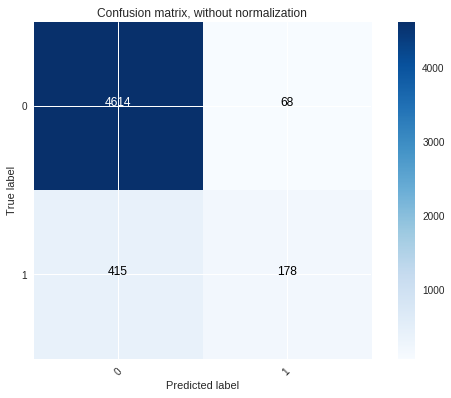

In [23]:
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

### For correctly predicted winners, what are typical values of dprice? Also plot distribution of dprice_test when winner is predicted but it's actually a loser on same axes.

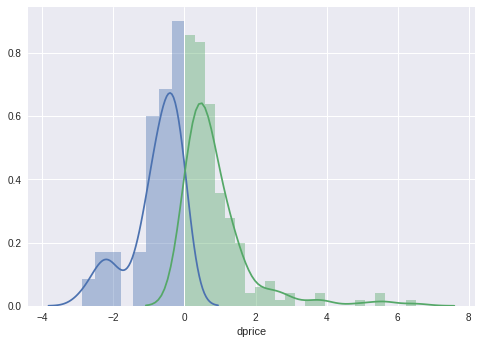

In [24]:
I2 = (dp_test > 0) & (dp_predict > 0)
dp_slice_winner = dp_test[I2]
dp_slice_loser = dp_test[(dp_test < 0) & (dp_predict > 0)]
#print dp_slice_loser.min(), dp_slice_loser.max(), dp_slice_loser.mean()
sns.distplot(dp_slice_loser)
sns.distplot(dp_slice_winner)
plt.show()

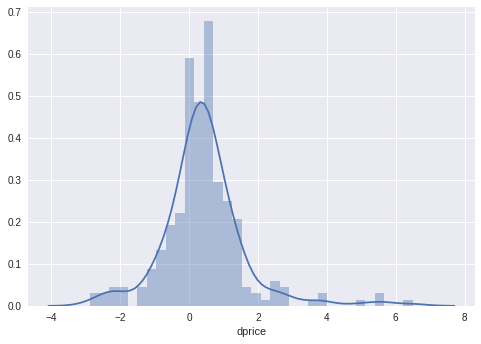

0.431382113821 1.20673696994


In [25]:
dp_predict_winner_density = dp_test[dp_predict > 0]
sns.distplot(dp_predict_winner_density)
plt.show()
print dp_predict_winner_density.mean(), dp_predict_winner_density.std()

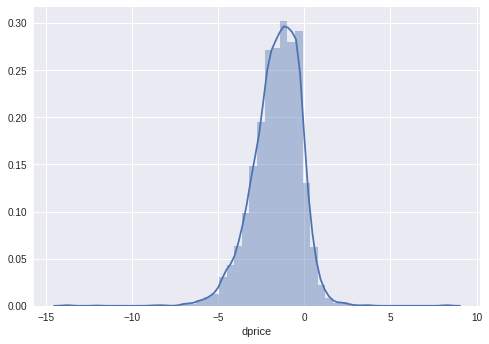

-1.6070540863 1.39238058289


In [26]:
#distribution of dprice when dp_predict < 0
dp_predict_loser_density = dp_test[dp_predict < 0]
sns.distplot(dp_predict_loser_density)
plt.show()
print dp_predict_loser_density.mean(), dp_predict_loser_density.std()

### Expected gains

In [27]:
I3 = dp_predict > 0
E = np.sum(dp_test[I3])/np.sum(I3)
print E

0.431382113821


In [28]:
clf.best_estimator_.feature_importances_[:20]

array([  2.14912295e-01,   1.04996256e-01,   2.30110357e-01,
         8.24658066e-02,   1.08812874e-01,   4.29130550e-03,
         2.30969325e-05,   2.02105592e-03,   4.28241187e-05,
         8.03418774e-03,   6.74989763e-03,   3.12404005e-03,
         1.66144577e-04,   1.02056539e-03,   4.16057831e-03,
         1.05997644e-03,   2.64576085e-05,   6.26012866e-04,
         1.07549924e-04,   1.30633660e-02])

In [29]:
important_features_indices = np.where(clf.best_estimator_.feature_importances_ > 0.01)
ordered_indices = sorted(range(s.shape[1]), key=clf.best_estimator_.feature_importances_.__getitem__)
ordered_indices.reverse()
ordered_indices[:20]

[2, 0, 4, 1, 3, 103, 19, 40, 52, 37, 68, 102, 9, 59, 64, 87, 65, 10, 44, 75]

In [31]:
list(s_test.columns[ordered_indices[:20]])

['maturity',
 'tradedate',
 'holdtime',
 'coupon',
 'rtg',
 'TOBACCO SETTLEMENT FUNDED',
 'Illinois',
 'Ohio',
 'Virgin Islands',
 'New York',
 'COLLEGE & UNIV. REV.',
 'TOBACCO & LIQUOR TAXES',
 'California',
 'GENERAL OBLIGATION UNLTD',
 'AD VALOREM PROPERTY TAX',
 'MISCELLANEOUS REVENUE',
 'APPROPRIATIONS',
 'Colorado',
 'Puerto Rico',
 'HIGHWAY REVENUE TOLLS']

In [32]:
clf.best_estimator_.feature_importances_[ordered_indices[:20]]

array([ 0.23011036,  0.2149123 ,  0.10881287,  0.10499626,  0.08246581,
        0.01448115,  0.01306337,  0.01078495,  0.00940098,  0.00871535,
        0.00835388,  0.00820441,  0.00803419,  0.00778409,  0.00740613,
        0.00710691,  0.00677976,  0.0067499 ,  0.00640016,  0.00634917])

### Pick out best estimator and save decision tree to file, using max_depth = 5. Make sure to label features appropriately and set filled = True and feature_names = list(s_test.columns)

In [82]:
#clf_best = clf.best_estimator_
#tree0 = clf_best.estimators_[21]
clf_dec = DecisionTreeRegressor(max_depth = 25, max_features = None, criterion = 'mse')
clf_dec.fit(s_train, dp_train)

DecisionTreeRegressor(criterion='mse', max_depth=25, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best')

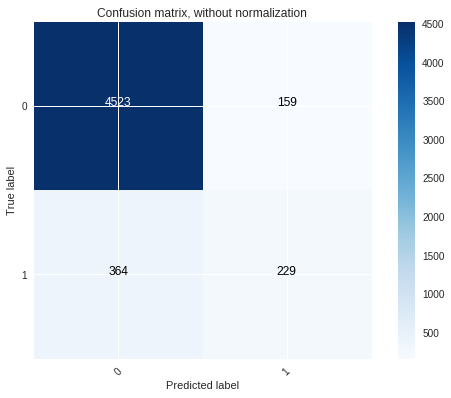

In [83]:
dp_predict_0 = clf_dec.predict(s_test)
cnf_matrix = confusion_matrix((dp_test>0).astype(np.int), (dp_predict_0>0).astype(np.int))
plt.figure()
visualize.plot_confusion_matrix(cnf_matrix, classes=[0, 1], title='Confusion matrix, without normalization')
plt.show()

In [279]:
tree.export_graphviz(clf_dec, 'dprice_decision_tree.dot', max_depth = 5, filled = True, feature_names = list(s_test.columns))

### To convert to .png, in the terminal type "dot -Tpng dprice_decision_tree_0.dot -o dprice_decision_tree_0.png"

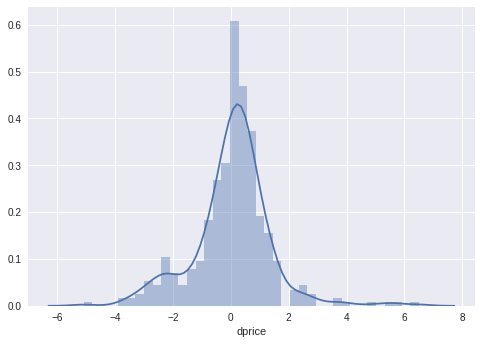

0.0424329896907 1.34530340205


In [85]:
dp_predict_0_winner_density = dp_test[dp_predict_0 > 0]
sns.distplot(dp_predict_0_winner_density)
plt.show()
print dp_predict_0_winner_density.mean(), dp_predict_0_winner_density.std()